<p>IPython Parallel must be installed before it can be used. On the Bash shell, in your preferred conda environment, run these two commands:</p>
<p>pip install ipyparallel</p>
<p>ipcluster start &</p>
<p>Once it is installed, launch jupter notebook. The cluster has. If it starts, then everything is ok, in spite of the error.</p>
<p>By default, this will start a local cluster on your own computer, utilizing your CPU's multiple cores if available.</p>

<p>Next, we open a notebook and import Client from IPython.parallel</p>

In [1]:
from ipyparallel import Client

we will create an instance of a Client object to work with

In [ ]:
c = Client()
c.block = True  # use synchronous computations

In [ ]:
c.ids

In [ ]:
c[:].apply(lambda : "Hello, World")

we can create a function...

In [ ]:
def mul(a, b):
    return a * b

...then specify that we want it to run on a single core...

In [ ]:
c[0].apply(mul, 5, 6)

...all cores with the same input...

In [ ]:
c[:].apply(mul, 5, 6)

...or we can specify which multiple cores by using index slicing...

In [ ]:
c[1:3].apply(mul, 5, 6)

we can pass different arguments to the cores by using the map function...

In [ ]:
view = c.load_balanced_view()
view.map(mul, [5, 6, 7, 8], [8, 9, 10, 11])

using a load-balanced view lets the IPython scheduler take care of farming the tasks for us

Load Balanced View: A load balanced view allows execution of a command on any one engine. Which engine is used is up to the scheduler:

IPython client and views
There is one primary object, the Client, for connecting to a cluster. For each execution model, there is a corresponding View. These views allow users to interact with a set of engines through the interface. Here are the two default views:

*The DirectView class for explicit addressing.
*The LoadBalancedView class for destination-agnostic scheduling.

In [ ]:
import os
import socket
print(os.getpid())
print(socket.gethostname())

The direct view is an interface in which each engine is directly exposed to the user.

In [ ]:
c.direct_view().apply(os.getpid)

In [ ]:
def get_pid_slowly():
    # imports in the function, otherwise these imports
    # don't happen on the engines
    import os
    import time
    import random
    
    # sleep up to 10 seconds
    time.sleep(10 * random.random())
    return os.getpid()

In [ ]:
c.block = True
c[:].apply(get_pid_slowly)

In [ ]:
c.block = False
c[:].apply(get_pid_slowly)

In [ ]:
resultSet = c[:].apply(get_pid_slowly)

In [ ]:
# just keep re-executing this code block...
resultSet.ready()

In [ ]:
resultSet.get()

to import modules like numpy on all the engines in our cluster we can use...

In [ ]:
c[:].execute('import numpy')

...or...

In [ ]:
with c[:].sync_imports():
    import numpy

...or...

In [ ]:
%px import numpy

DirectView: Scatter and Gather

One very useful way to push and pull data is using the scatter() and gather() commands. This will take an array and partition it among the parallel instances:

In [ ]:
c[:].scatter('a', numpy.arange(24))
c[:]['a']

Notice that the contents of a are partitioned and scattered among the instances. To bring them back, we can use gather():

In [ ]:
a = c[:].gather('a')
a.get()

In [ ]:
dview = c.direct_view()
A = numpy.random.random((8, 3))
dview.scatter('A', A)
print(A)

for chunk in dview['A']:
    print(chunk)

In [ ]:
c.block = True
def parallel_dot(dview, A, B):
    dview.scatter('A', A)
    dview['B'] = B
    dview.execute('C = numpy.dot(A, B)')
    return dview.gather('C')
dview = c.direct_view()
A = numpy.random.random((1, 3))
B = numpy.random.random((3, 1))

print(A)
print(B)
print('')
print(parallel_dot(dview, A, B))

numpy.allclose(parallel_dot(dview, A, B),
            numpy.dot(A, B))

In [ ]:
numpy.allclose?

monte carlo pi estimation example

In [ ]:
def sample(n):
    return (rand(n) ** 2 + rand(n) ** 2 <= 1).sum()

In [ ]:
with c[:].sync_imports():
    from numpy.random import rand

In [ ]:
n = 10000000
4 * sum(c[:].map_sync(sample, [n] * len(c[:]))) / (n * len(c[:]))

In [2]:
def mandel1(x, y, max_iters=1000):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [3]:
rc = Client()
dv = rc[:]
@dv.parallel(block = True)
def mandel2(x, y, max_iters=1000):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [4]:
import numpy as np
x = np.arange(-2, 1, 0.001)
y = np.arange(-1, 1, 0.001)
X, Y = np.meshgrid(x, y)

In [5]:
%%time
im1 = np.reshape(list(map(mandel1, X.ravel(), Y.ravel())), (len(y), len(x)))

CPU times: user 6min 17s, sys: 265 ms, total: 6min 17s
Wall time: 6min 17s


In [6]:
%%time
im2 = np.reshape(mandel2.map(X.ravel(), Y.ravel()),  (len(y), len(x)))

CPU times: user 549 ms, sys: 76 ms, total: 625 ms
Wall time: 2min 9s


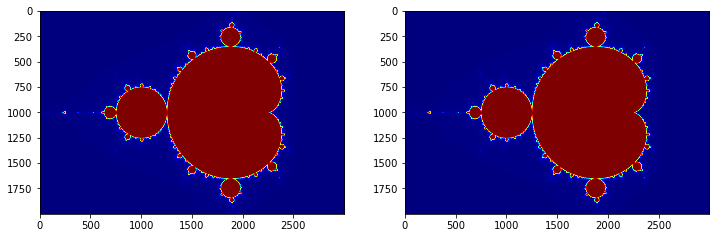

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].grid(False)
axes[0].imshow(im1, cmap='jet')
axes[1].grid(False)
axes[1].imshow(im2, cmap='jet')
plt.show()